# Convolutional Neural Networks on CIFAR-10

This notebook performs classification on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The following concepts are explored:

- Manual definition of a CNN similar to LeNet to test classification.
- Data augmentation for a better generalization.
- Transfer learning for a better classification.
- Training on a CUDA device, Jetson Nano per SSH.

In order to use these examples, we need to install Pytorch in out environment (eg., by using Anaconda):

```bash
conda create -n myenv python=3.6
source activate myenv
conda install opencv-python matplotlib numpy pillow jupyter scipy pandas
conda install pytorch torchvision -c pytorch
# I had some issues with numpy and torch
pip uninstall numpy
pip uninstall mkl-service
pip install numpy
pip install mkl-service
```

I used my `dlnd` environment.

For a more detailed guide on Deep Learning and its implementation and use with Pytorch, have a look at my complete repository on that topic:

[deep_learning_udacity](https://github.com/mxagar/deep_learning_udacity)

I have used several source files to compile this project, mainly from Udacity:

[deep-learning-v2-pytorch](https://github.com/mxagar/deep-learning-v2-pytorch)

- `/convolutional-neural-networks/cifar-cnn/`
- `/transfer-learning/`

### Overview of Contents

1. [Imports and Test for CUDA](#1.-Imports-and-Test-for-CUDA)
2. [Load and Augment the Data](#2.-Load-and-Augment-the-Data)

    - 2.1 Visualize the Dataset

3. [Define the CNN Manually](#3.-Define-the-CNN-Manually)

    - 3.1 Loss Function and Optimizer

4. [Train the Network](#4.-Train-the-Network)

    - 4.1 Load the Best Network

5. [Evaluate the Network](#5.-Evaluate-the-Network)

    - 5.1 Visualize Some Results

6. [Remote Execution on CUDA Device, Jetson Nano](#6.-Remote-Execution-on-CUDA-Device,-Jetson-Nano)

7. [Transfer Learning](#7.-Transfer-Learning)

    - 7.1 Load Backbone and Modify Classifier
    - 7.2 Train
    - 7.3 Evaluate
    - 7.4 Visualize Some Results

## 1. Imports and Test for CUDA

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## 2. Load and Augment the Data

The dataset is automatically downloaded to the local folder `data`. In order to increase invariance and generalization, we augment the data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100.0%

Files already downloaded and verified


### 2.1 Visualize the Dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

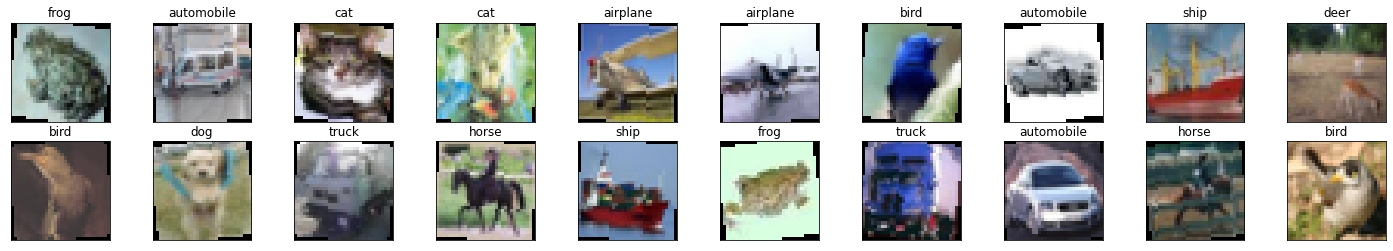

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## 3. Define the CNN Manually

Useful guidelines:

- Usual architecture: 2-4 `Conv2d` with `MaxPool2d`in-between so that the size is halved; at the end 1-3 fully connected layers with dropout in-between to avoid overfitting.
- Recall that an image has the shape `B x W x H x D`. The bacth size `B` is usually not used during the network programming, but it's there, even though we feed one image per batch!
- In the convolutions:
    - Prefer small 3x3 filters; use odd numbers in any case.
    - Use padding so that the size of the image is preserved! That means taking `padding=floor(F/2)`.
    - Recall the size change formula: `W_out = (W_in + 2P - F)/S + 1`.
- Use `relu()` activation after each convolution, but not after max-pooling.
- If we use a unique decreasing factor in `MaxPool2d`, it's enough defining a unique `MaxPool2d`.
- The typical max-pooling is the one which halvens the size: `MaxPool2d(2,2)`.
- Before entering the fully connected or linear layer, we need to flatten the feature map:
    - In the definition of `Linear()`: we need to compute the final volume of the last feature map set. If we preserved the sized with padding it's easy; if not, we need to apply the formula above step by step.
    - In the `forward()` method: `x = x.view(x.size(0), -1)`; `x.size(0)`is the batch size, `-1` is the rest. 
- If we use `CrossEntropyLoss()`, we need to return the `relu()` output; if we return the `log_softmax()`, we need to use the `NLLLoss()`. `CrossEntropy() == log_softmax() + NLLLoss()`.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### 3.1 Loss Function and Optimizer

In [10]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 4. Train the Network

The validation split is tested after each epoch. The model with the smallest validation loss is saved.

In [ ]:
# Training device
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# Track losses
train_loss_array = []
valid_loss_array = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses & save them
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_loss_array.append(train_loss)
    valid_loss_array.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

### 4.1 Load the Best Network

Take into account that we need to map the weights to the CPU if the network was trained on the GPU but we are loading it to the CPU!

In [13]:
if train_on_gpu:
    model.load_state_dict(torch.load('model_augmented.pt'))
else:
    model.load_state_dict(torch.load('model_augmented.pt',map_location=torch.device('cpu')))

## 5. Evaluate the Network

In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.710989

Test Accuracy of airplane: 79% (791/1000)
Test Accuracy of automobile: 88% (880/1000)
Test Accuracy of  bird: 57% (571/1000)
Test Accuracy of   cat: 54% (543/1000)
Test Accuracy of  deer: 72% (727/1000)
Test Accuracy of   dog: 63% (631/1000)
Test Accuracy of  frog: 88% (882/1000)
Test Accuracy of horse: 81% (813/1000)
Test Accuracy of  ship: 86% (860/1000)
Test Accuracy of truck: 82% (825/1000)

Test Accuracy (Overall): 75% (7523/10000)


### 5.1 Visualize Some Results

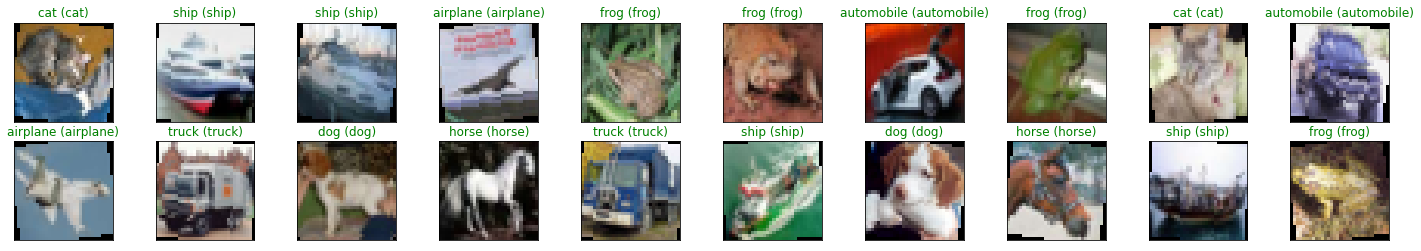

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## 6. Remote Execution on CUDA Device, Jetson Nano

The code in this notebook is ready to be executed on a CUDA device, like a Jetson Nano. In order to set up the Jetson Nano, we need to follow the steps in 

    ~/Dropbox/Documentation/howtos/jetson_nano_howto.txt

I created the guide following experimenting myself two very important links:

- [Getting Started with Jetson Nano, Medium](https://medium.com/@heldenkombinat/getting-started-with-the-jetson-nano-37af65a07aab)
- [Getting Started with Jetson Nano, NVIDIA](https://developer.nvidia.com/embedded/learn/get-started-jetson-nano-devkit#intro)

In the following, a basic usage guide is provided; for setup, look at the howto file above.

####  Summary of Installation Steps

- Flash SD image
- Create account in Jetson Ubuntu (18): mxagar, pw
- Install basic software
- Create python environment: `env`
- Install DL packages in python environment: Pytorch, Torchvision, PIL, OpenCV, etc.

####  How to Connect to Jetson via SSH

    ssh mxagar@jetson-nano.com

#### Connect to a Jupyter Notebook Run on the Jetson from Desktop


Open new Terminal on Mac: start SSH tunneling and leave it open
    
    ssh -L 8000:localhost:8888 mxagar@jetson-nano.local

Open new Terminal on Mac (or the same works also): connect to jetson-nano & start jupyter
        
    ssh mxagar@jetson-nano.local
    source ~/python-envs/env/bin/activate
    cd /your/path
    jupyter notebook
        or jupyter-lab
        in both cases, look for token
            http://localhost:8888/?token=XXX
                
Open new browser on Mac, go to
     
    http://localhost:8000
    insert token XXX

#### SFTP Access

Currently, I cannot access via SFTP the Jetson Nano. Some configuration is needed, which I didn't have time to go through. As a workaround, I clone and pull/push the repositories to the Jetson directly after connecting via SSH.

## 7. Transfer Learning

We can apply transfer learning by using the pre-trained models in Pytorch: [Torchvision Models](https://pytorch.org/vision/0.8/models.html).

Basically, we follow these steps:

- Load the desired model with the pretrained weights.
- Print the model to check its implemente layers and nodes. We can access layer groups (often `features` and `classifier`) and layers (with indices).
- Freeze the weights of the desired layers: `requires_grad = False`.
- We define a new last layer in the classifier which maps to our desired number of classes.
- We create a new criterion and a new optimizer with the weights to re-compute: the ones of the `classifier`.
- Re-train for a few epochs; since it's transfer learning, usually we don't need to train for very long.

An important point not throughly covered here is the normalization: we should apply to our images the same normalization as the the one applied to the backbone.

Additionally, transfer learning makes more sense with aan own dataset in which new images are learned to classify, e.g., flower types. See [deep-learning-v2-pytorch](https://github.com/mxagar/deep-learning-v2-pytorch) `/transfer-learning/`.

Finally: consider the 4 quadrants defined by `dataset size vs. similarity` to chosse between transfer learning vs. fine tuning.

### 7.1 Load Backbone and Modify Classifier

In [27]:
from torchvision import models

# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [29]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [30]:
import torch.nn as nn

# compute number of inputs
n_inputs = vgg16.classifier[6].in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

10


In [31]:
import torch.optim as optim

# Specify loss function: categorical cross-entropy
# because classification and last layer has no activation
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
# Note that ONLY the parameters of the classifier are passed!
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

### 7.2 Train

In [32]:
len(train_loader)

2000

In [33]:
# Number of epochs to train the model
# We don't need to use a lot of epochs now
n_epochs = 3

train_loss_array = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        
        if batch_i % 200 == 199:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 200))
            train_loss_array.append(train_loss/200)
            train_loss = 0.0

Epoch 1, Batch 200 loss: 19.6206583440303817
Epoch 1, Batch 400 loss: 16.5679507493972764
Epoch 1, Batch 600 loss: 16.0626845985651023
Epoch 1, Batch 800 loss: 15.4329493522644050
Epoch 1, Batch 1000 loss: 15.2374719232320786
Epoch 1, Batch 1200 loss: 15.2726630359888080
Epoch 1, Batch 1400 loss: 14.7409655779600151
Epoch 1, Batch 1600 loss: 14.8310122072696693
Epoch 1, Batch 1800 loss: 14.7336960911750801
Epoch 1, Batch 2000 loss: 14.5312719732522968
Epoch 2, Batch 200 loss: 14.3596624940633770
Epoch 2, Batch 400 loss: 14.2075430452823639
Epoch 2, Batch 600 loss: 14.3446558952331547
Epoch 2, Batch 800 loss: 14.0499161154031746
Epoch 2, Batch 1000 loss: 13.9335390746593468
Epoch 2, Batch 1200 loss: 13.9159670203924186
Epoch 2, Batch 1400 loss: 13.9084307610988613
Epoch 2, Batch 1600 loss: 13.8470859378576279
Epoch 2, Batch 1800 loss: 13.7583327710628502
Epoch 2, Batch 2000 loss: 13.6955983519554145
Epoch 3, Batch 200 loss: 13.5150083541870121
Epoch 3, Batch 400 loss: 13.448018020391463

### 7.3 Evaluate

The evaluation results are considerably worse than with the manually defined CNN. Maybe we need to train the network for more epochs?

In [42]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

vgg16.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.266180

Test Accuracy of airplane: 66% (661/1000)
Test Accuracy of automobile: 61% (618/1000)
Test Accuracy of  bird: 33% (331/1000)
Test Accuracy of   cat: 43% (433/1000)
Test Accuracy of  deer: 47% (470/1000)
Test Accuracy of   dog: 51% (516/1000)
Test Accuracy of  frog: 72% (727/1000)
Test Accuracy of horse: 61% (610/1000)
Test Accuracy of  ship: 58% (585/1000)
Test Accuracy of truck: 64% (642/1000)

Test Accuracy (Overall): 55% (5593/10000)


### 7.4 Visualize Some Results

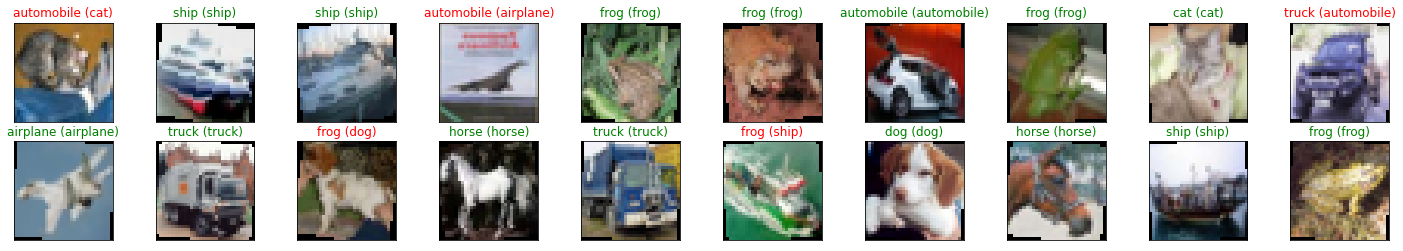

In [44]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))